# K-means implementation for Cuda

--------

# Introduction

**Note :**
- > Tous les calculs sont effectués sur un ordinateur de 
        - > 16Go de Ram
        - > Intel® Core™ i7-4700HQ CPU @ 2.40GHz × 8 
        - > GeForce GT 750M/PCIe/SSE2

# I. Preliminaries

- ### Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

from math import sqrt
import random
from sklearn.cluster import KMeans
import scipy

- ### Simulate data

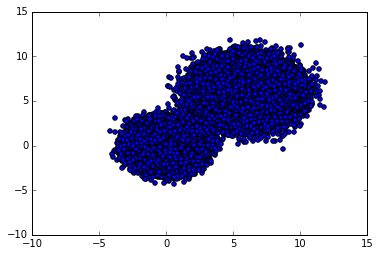

In [12]:
nb_point=100000
X = np.concatenate([np.random.multivariate_normal([0,0],[[1,0],[0,1]],nb_point),
                  np.random.multivariate_normal([6,6],[[2,0],[0,2]],nb_point)])

plt.scatter(X[:,0],X[:,1])
#change plot size

# II. Sequential approach

- ### Stanford approach

In [28]:
def kmeans(dataSet, k,MAX_ITERATIONS,epsi=0.01):

    # Initialize centroids randomly
    numFeatures = getNumFeatures(dataSet)
    centroids = getRandomCentroids(dataSet, k)
    
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.random.random([k,numFeatures]) #None
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS,k,epsi):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(dataSet,numFeatures, labels, k)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    clusters=getClusters(dataSet,centroids,k)
    return centroids, clusters


def shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS,k,epsi):
    """
    Returns True or False if k-means is done. K-means terminates either
    because it has run a maximum number of iterations OR the centroids
    have reached an equilibrium.
    """
    quality=sum(np.sqrt(((oldCentroids-centroids)**2).sum(axis=1)))/k  #to change in the future
    if (iterations > MAX_ITERATIONS) | (quality<=epsi) : 
        print('Stoped at iteration : %s' %(iterations))
        if iterations > MAX_ITERATIONS:
            print('Max iterations reached, equilibrium quality of %s superior to espilon' %(quality))
        else:
            print('Equilibrium reached for epsilon = %s' %(epsi))
        return True
    else:
        return False
    
    
def getLabels(dataSet, centroids):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """

    mat=np.zeros(np.shape(dataSet))
    i=0
    for row in dataSet:
        dist=np.sqrt(((row-centroids)**2).sum(axis=1))
        index=np.argmin(dist,axis=0)
        mat[i]=centroids[index]
        i=i+1
    return mat


def getCentroids(dataSet,numFeatures, labels, k):
    """
    Returns k centroids, each of dimension n
    Each centroid is the geometric mean of the points that
    have that centroid's label. Important: If a centroid is empty (no points have
    that centroid's label) you should randomly re-initialize it.
    """

    #check centroids who are missing:
    sorted_data =  labels[np.lexsort(labels.T),:]
    row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
    uniques=sorted_data[row_mask]
    
    #compute mean:
    centroids=np.zeros(np.shape(uniques))
    j=0
    for row in uniques:
        index=np.where(np.all(labels==row,axis=1))[0]
        #print(np.mean(dataSet[index],axis=0))
        centroids[j]=np.mean(dataSet[index],axis=0)
        j=j+1
    
    #Check number of centroids non attributed to a point
    i=k-np.shape(centroids)[0]
    
    if i==0:
        return centroids
    else:
        #concat with random missing centroids:
        print('Missing %s centroids' %(i))
        return np.concatenate([centroids,getRandomCentroids(dataSet, i)])
    
def getRandomCentroids(dataSet, k):
    """
    Returns k random centroids, each of dimension n
    For init phase, value should take a random
    position in set of range
    """
    #np.random.uniform(np.min(dataSet),np.max(dataSet),(k,numFeatures))
    #np.random.random([k,numFeatures])
    idx = np.random.randint(np.shape(dataSet)[0], size=k)
    
    return dataSet[idx,:]


def getNumFeatures(dataSet):
    """
    Returns dimensions of dataset : n-dimensions or
    n-features.
    """
    return np.shape(dataSet)[1]

def getClusters(dataSet,centroids,k):
    """
    Returns an array of scalars (1:k) of dimension nb_points.
    """
    clusters= [None]*np.shape(dataSet)[0] #np.zeros((1,np.shape(dataSet)[1]))
    for i,x in enumerate(dataSet):
        clusters[i] = min(range(k), key=lambda j: np.sqrt(((dataSet[i]-centroids[j])**2).sum(axis=0)))
    return clusters

In [4]:
%%time
t=kmeans(X,3,100)

Stoped at iteration : 5
Equilibrium reached for epsilon = 0.01
CPU times: user 11 s, sys: 36 ms, total: 11.1 s
Wall time: 11 s


In [5]:
%%time
t=kmeans(X,2,100,epsi=-1)

Stoped at iteration : 101
Max iterations reached, equilibrium quality of 0.0 superior to espilon
CPU times: user 2min 25s, sys: 236 ms, total: 2min 25s
Wall time: 2min 25s


In [6]:
%%time
t=kmeans(X,2,100,epsi=0.0)

Stoped at iteration : 6
Equilibrium reached for epsilon = 0.0
CPU times: user 9.95 s, sys: 20 ms, total: 9.97 s
Wall time: 9.95 s


CPU times: user 436 ms, sys: 0 ns, total: 436 ms
Wall time: 432 ms


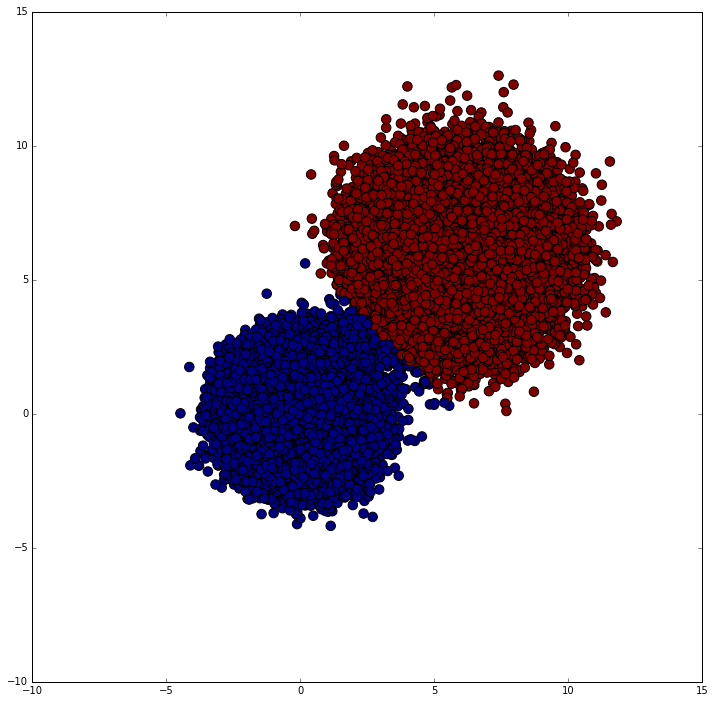

In [7]:
%%time
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:,1],c=t[1],s=90)

- ## Other approach

In [8]:
def dist(x1, x2):
    ''' Distance between two points '''
    return np.sqrt(sum((x1-x2)**2))


def kmeans_(X,k, n_iter=100):
    # Initialize from random points.
    centers = [X[i, :] for i in random.sample(range(np.shape(X)[0]), k)]
    cluster = [None] * np.shape(X)[0]
 
    for _ in range(n_iter):
        for i, x in enumerate(X):
            cluster[i] = min(range(k), key=lambda j: dist(x, centers[j]))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if cluster[i] == j]
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
    return  np.array(centers),cluster


In [9]:
%%time
t=kmeans_(X,2,100)

CPU times: user 3min 5s, sys: 1.37 s, total: 3min 7s
Wall time: 3min 5s


CPU times: user 472 ms, sys: 4 ms, total: 476 ms
Wall time: 469 ms


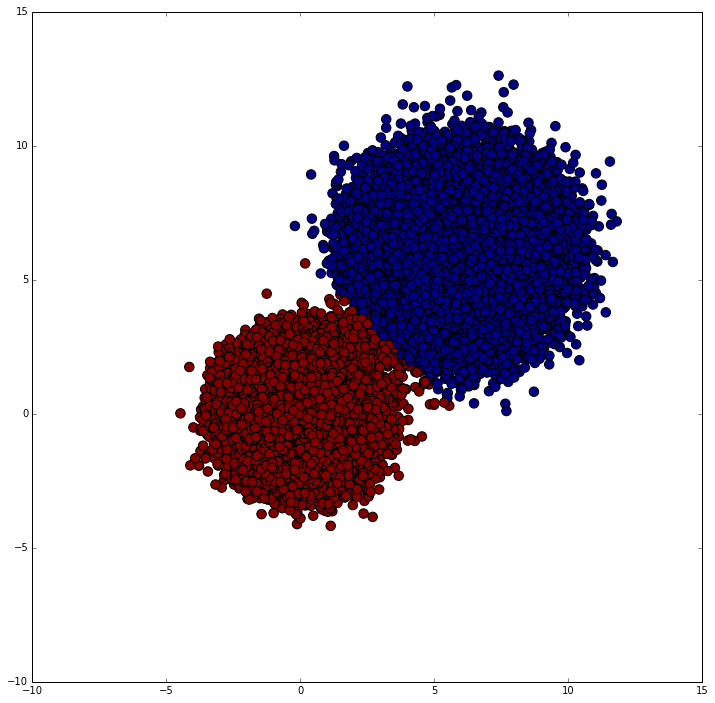

In [10]:
%%time
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:,1],c=t[1],s=90)

In [11]:
# Compare with sklearn
%time KMeans(n_clusters=2, n_init=1, max_iter=100, n_jobs=1).fit(X)

CPU times: user 92 ms, sys: 280 ms, total: 372 ms
Wall time: 66.8 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

- ## Test on image segmentation:

Sample size : [276480, 3]


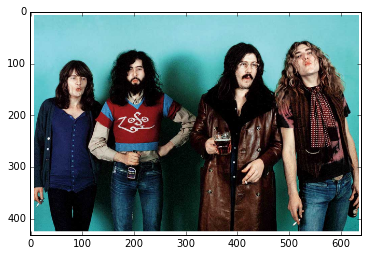

In [12]:
image = scipy.misc.imread('../data/images/orig.png')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
samples = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])
print('Sample size : %s' %(list(np.shape(samples))) )

In [13]:
%%time
k = kmeans(samples,6,100,epsi=0.0)
labels = np.array(k[1])

Stoped at iteration : 57
Equilibrium reached for epsilon = 0.0
CPU times: user 2min 11s, sys: 200 ms, total: 2min 11s
Wall time: 2min 11s


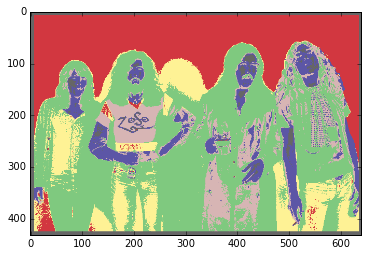

In [14]:
plt.imshow(labels.reshape((w,h)), cmap=plt.cm.Accent)

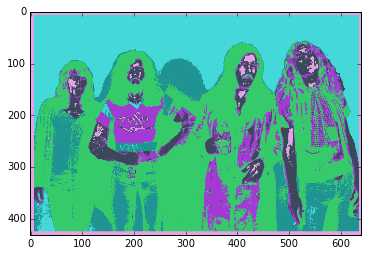

In [15]:
arr = []
for i in labels:
    arr.append(k[0][i])  

reconstruct = np.array(arr).reshape((w,h, 3))
plt.imshow(reconstruct)

Unfortunately as you can see the colors are all screwed up compared to the original image. This is because we are using the means which are vectors of floating point numbers. To be able to interpret the image correctly we need to convert these floats to integers:

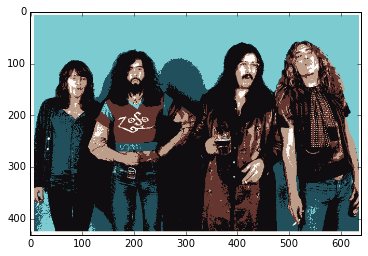

In [16]:
arr = []
for i in labels:
    arr.append(k[0][i].astype(np.uint8))
reconstruct = np.array(arr).reshape((w,h, 3))
plt.imshow(reconstruct)

# III. Parallel approach

In [9]:
import numba
from numba import cuda, vectorize, guvectorize #, check_cuda
from numba import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8

@vectorize(['float32(float32, float32)'], target='cuda')
def Add(a, b):
    return a + b

N=10000000
# Initialize arrays
A = np.ones(N, dtype=np.float32)
B = np.ones(A.shape, dtype=A.dtype)
C = np.empty_like(A, dtype=A.dtype)

# Add arrays on GPU
%time C = Add(A, B)

CPU times: user 96 ms, sys: 8 ms, total: 104 ms
Wall time: 102 ms


In [55]:
def kmeans(dataSet, k,MAX_ITERATIONS,epsi=0.01):

    # Initialize centroids randomly
    numFeatures = getNumFeatures(dataSet)
    centroids = getRandomCentroids(dataSet, k)
    
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.random.random([k,numFeatures]) #None
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS,k,epsi):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        mat=np.zeros(np.shape(dataSet))
        labels = getLabels(dataSet, centroids,mat)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(dataSet,numFeatures, labels, k)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    clusters=getClusters(dataSet,centroids,k)
    return centroids, clusters


def shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS,k,epsi):
    """
    Returns True or False if k-means is done. K-means terminates either
    because it has run a maximum number of iterations OR the centroids
    have reached an equilibrium.
    """
    quality=sum(np.sqrt(((oldCentroids-centroids)**2).sum(axis=1)))/k  #to change in the future
    if (iterations > MAX_ITERATIONS) | (quality<=epsi) : 
        print('Stoped at iteration : %s' %(iterations))
        if iterations > MAX_ITERATIONS:
            print('Max iterations reached, equilibrium quality of %s superior to espilon' %(quality))
        else:
            print('Equilibrium reached for epsilon = %s' %(epsi))
        return True
    else:
        return False

@cuda.jit
def getLabels(dataSet, centroids,mat):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    
    #mat=np.zeros(np.shape(dataSet))
    i=0
    d=np.vectorize(lambda t: sqrt(t))
    for row in dataSet:
        dist=d(((row-centroids)**2).sum(axis=1))
        index=np.argmin(dist,axis=0)
        mat[i]=centroids[index]
        i=i+1
    return mat


def getCentroids(dataSet,numFeatures, labels, k):
    """
    Returns k centroids, each of dimension n
    Each centroid is the geometric mean of the points that
    have that centroid's label. Important: If a centroid is empty (no points have
    that centroid's label) you should randomly re-initialize it.
    """

    #check centroids who are missing:
    sorted_data =  labels[np.lexsort(labels.T),:]
    row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
    uniques=sorted_data[row_mask]
    
    #compute mean:
    centroids=np.zeros(np.shape(uniques))
    j=0
    for row in uniques:
        index=np.where(np.all(labels==row,axis=1))[0]
        #print(np.mean(dataSet[index],axis=0))
        centroids[j]=np.mean(dataSet[index],axis=0)
        j=j+1
    
    #Check number of centroids non attributed to a point
    i=k-np.shape(centroids)[0]
    
    if i==0:
        return centroids
    else:
        #concat with random missing centroids:
        print('Missing %s centroids' %(i))
        return np.concatenate([centroids,getRandomCentroids(dataSet, i)])
    
def getRandomCentroids(dataSet, k):
    """
    Returns k random centroids, each of dimension n
    For init phase, value should take a random
    position in set of range
    """
    #np.random.uniform(np.min(dataSet),np.max(dataSet),(k,numFeatures))
    #np.random.random([k,numFeatures])
    idx = np.random.randint(np.shape(dataSet)[0], size=k)
    
    return dataSet[idx,:]


def getNumFeatures(dataSet):
    """
    Returns dimensions of dataset : n-dimensions or
    n-features.
    """
    return np.shape(dataSet)[1]

def getClusters(dataSet,centroids,k):
    """
    Returns an array of scalars (1:k) of dimension nb_points.
    """
    clusters= [None]*np.shape(dataSet)[0] #np.zeros((1,np.shape(dataSet)[1]))
    for i,x in enumerate(dataSet):
        clusters[i] = min(range(k), key=lambda j: np.sqrt(((dataSet[i]-centroids[j])**2).sum(axis=0)))
    return clusters

In [29]:
mat=np.zeros(np.shape(X))
@vectorize(['float32(float32[:,:], float32[:,:], float32[:,:])'],target='cuda')    
def getLabels(dataSet, centroids,mat=mat):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    
    #mat=np.zeros(np.shape(dataSet))
    i=0
    for row in dataSet:
        dist=np.sqrt(((row-centroids)**2).sum(axis=1))
        index=np.argmin(dist,axis=0)
        mat[i]=centroids[index]
        i=i+1
    return mat

TypingError: Caused By:
Traceback (most recent call last):
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/compiler.py", line 243, in run
    res = stage()
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/compiler.py", line 458, in stage_nopython_frontend
    self.locals)
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/compiler.py", line 759, in type_inference_stage
    infer.propagate()
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/typeinfer.py", line 510, in propagate
    raise errors[0]
TypingError: No conversion from array(float32, 2d, A) to float32 for '$103.2'

Failed at nopython (nopython frontend)
No conversion from array(float32, 2d, A) to float32 for '$103.2'

In [56]:
%%time
t=kmeans(X,2,100,epsi=-1)

AttributeError: Caused By:
Traceback (most recent call last):
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/compiler.py", line 228, in run
    stage()
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/compiler.py", line 364, in stage_analyze_bytecode
    func_ir = translate_stage(self.func_id, self.bc)
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/compiler.py", line 756, in translate_stage
    return interp.interpret(bytecode)
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/interpreter.py", line 97, in interpret
    self.dfa.run()
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/dataflow.py", line 27, in run
    self.infos[blk.offset] = self.run_on_block(blk)
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/dataflow.py", line 71, in run_on_block
    self.dispatch(info, inst)
  File "/home/duc-vinh/anaconda2/lib/python2.7/site-packages/numba/dataflow.py", line 80, in dispatch
    fn = getattr(self, fname)
AttributeError: 'DataFlowAnalysis' object has no attribute 'op_MAKE_FUNCTION'

Failed at nopython (analyzing bytecode)
'DataFlowAnalysis' object has no attribute 'op_MAKE_FUNCTION'